<a href="https://colab.research.google.com/github/KevinSikorskiBase2S/machine-learning-intro-workshop/blob/master/StyleGanCats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let there be cats!

This page adapted from https://github.com/t04glovern/aws-s3-cat-images by Nathan Glover.
Adaptation by Kevin Sikorski

In [0]:
!git clone https://github.com/NVlabs/stylegan
%cd stylegan

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import config
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import dnnlib.tflib as tflib
import tensorflow as tf
import random
from PIL import Image, ImageOps
from IPython.display import display
import scipy.misc

tflib.init_tf()

### Download and open the pre-trained network

In [0]:
url_cats = 'https://drive.google.com/uc?id=1MQywl0FNt6lHu8E_EUqnRbviagS7fbiJ' # karras2019stylegan-cats-256x256.pkl

with dnnlib.util.open_url(url_cats, cache_dir=config.cache_dir) as f:
    _G, _D, Gs = pickle.load(f)

### Set Random Seed

In [0]:
rnd = np.random.RandomState(1)

### Display a cat

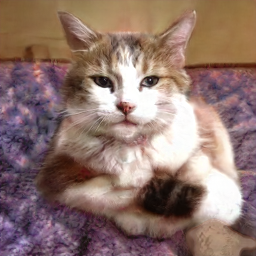

In [4]:
latents = rnd.randn(1, Gs.input_shape[1])
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
images = Gs.run(latents, None, truncation_psi=0.5, randomize_noise=True, output_transform=fmt)
img = Image.fromarray(images[0])
display(img)

### Display it bigger
Just a naive upscaling, no pretty smoothing involved.

(-0.5, 255.5, 255.5, -0.5)

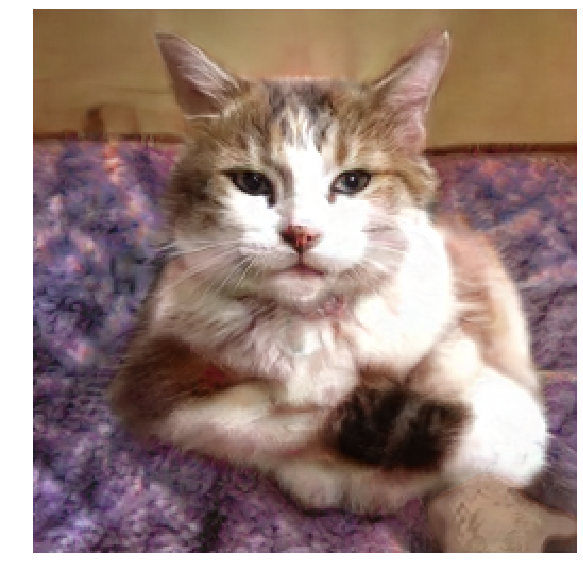

In [5]:
plt.figure(figsize=(10,10))
fig=plt.imshow(np.asarray(img))
plt.axis('off')

## Make a Cat Video

First some imports

In [0]:
import moviepy.editor
from moviepy.editor import VideoFileClip, concatenate_videoclips

### Define some functions to make life easier

In [0]:
# Generates the frame for time t
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    src_image = src_images[frame_idx]
    return np.array(src_image)

# Interpolates where we are in the latent space given what frame we are in
def get_latent(frame,latents):
  segment=int(frame/frames_per_seg)
  left_latent=latents[segment]
  right_latent=latents[segment+1]
  frame_in_seg=frame % frames_per_seg
  coef=frame_in_seg/frames_per_seg
  return coef*right_latent+(1-coef)*left_latent

def generate_image_for_video(latent_vector):
    images = Gs.run(latent_vector, None, truncation_psi=1, randomize_noise=False, output_transform=fmt)
    return images[0]

### Set up some constants
Most interesting are the random number seed, number of segments, and seconds per segment.

In [0]:
# Set up our random number generator: select a seed and how many to skip under that seed.
rnd = np.random.RandomState(14)
skip_for_realignment = 0
for i in range(skip_for_realignment):
  rnd.randn(1, Gs.input_shape[1])

# Define attributes of our video
num_segments = 16
sec_per_seg = 8
duration_sec = sec_per_seg*num_segments
smoothing_sec = 1.0
mp4_fps = 20
frames_per_seg = mp4_fps*sec_per_seg
num_frames = int(np.rint(duration_sec * mp4_fps))


### Generate the frames and write out the movie.

In [0]:
# Build our latent vectors.
all_latents = [rnd.randn(1, Gs.input_shape[1]) for _ in range(num_segments+1)]

# Build our images.
print("Generating {frames} images for movie...".format(frames=int(duration_sec*mp4_fps)))
src_images = np.stack(generate_image_for_video(get_latent(frame, all_latents)) for frame in range (num_frames))

# Generate video.
mp4_file = '/content/multiInterpolate.mp4'
mp4_codec = 'libx264'
mp4_bitrate = '5M'
print("About to make final video clip...")
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

### Download the file
If this fails (it probably will), just run it again.  It seems to take a couple seconds or a failed attempt for the file to appear.  The joys of the Cloud...

Even if you get a file out of this, it sometimes is a bad file, especially if it's on the longer side.  Just download it manually in that case (use the tab on the left, go to Files, and double-click).

In [0]:
from google.colab import files
import time

time.sleep(15) # Seems like we need to give the Cloud some time to catch up with us?

try:
  files.download(mp4_file)
except:
  print("First attempt to download failed")
  time.sleep(15) # Seems like we need to give the Cloud some time to catch up with us?
  print("Trying to download a second time")
  files.download(mp4_file)